In [1]:
import re

datapath = "data/neko.txt.cabocha"

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

### 準備
 ```
 brew install cabocha
 cabocha -f1 neko.txt > neko.txt.cabocha
 ```
 
### memo
クラスに`__str__`を定義するとprint等で呼ばれた時の表示方法を指定できる


In [2]:
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
        self.jp2en = {"表層形": surface, "基本形": base, "品詞": pos, "品詞細分類1": pos1}
    
    def __str__(self):
        return self.surface
    
    def check(self, speech, kind):
        return self.jp2en[speech] == kind

In [3]:
prg_morph = re.compile(r"(?P<sur>.+?)\t(?P<pos>[^,]+),(?P<pos1>[^,]+),([^,]+,){4}(?P<base>[^,]+).*")

def gen_sentence_morph():
    morph_list = []
    with open(datapath, encoding="utf-8") as f:
        for line in f:
            res_m = prg_morph.match(line)
            if res_m:
                morph_list.append(Morph(res_m.group("sur"), res_m.group("base"), res_m.group("pos"), res_m.group("pos1")))
            elif line == "EOS\n":
                yield morph_list
                morph_list = []

for i, sentence in enumerate(gen_sentence_morph()):
    if i== 3:
        print(list(map(str,sentence)))
        break
            

['名前', 'は', 'まだ', '無い', '。']


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

### memo
文節、形態素、文末の判定は正規表現でやる

1. 文節

    - 形態素は以降の行に書いてあるので後でappendするための受け皿をつくっておく。
    - 係り元を覚えておくための辞書を作る。日本語は係り先の方が文の後ろにあるから先読みせず1行ずつ処理可能
    - EOSが2行以上連なってるところが1文にカウントされてしまっている
    
2. 形態素

    4章を丸々流用

In [4]:
class Chunk:
    def __init__(self, index, dst, srcs):
        self.morphs = []
        self.index = index
        self.dst = dst
        self.srcs = srcs
    
    def __str__(self):
        "形態素をくっつけたものを表示(句読点除く)"
        return re.sub('[、。「」]', '', ''.join(map(str, self.morphs)))
    
    def __int__(self):
        "文中での通し番号を返す"
        return self.index
    
    def append(self, morph):
        "文節に形態素を追加"
        self.morphs.append(morph)
        
    def get(self, speech, kind):
        "品詞(speech)が特定の種類(kind)の形態素のみを取り出す"
        return [morph for morph in self.morphs if morph.check(speech, kind)]

In [5]:
from collections import defaultdict

prg_morph = re.compile(r"(?P<sur>.+?)\t(?P<pos>[^,]+),(?P<pos1>[^,]+),([^,]+,){4}(?P<base>[^,]+).*")
prg_chunk = re.compile(r"\* (?P<num>\d+) (?P<dst>-?\d+)D \d+/\d+ .*")

def gen_sentence():
    chunk = None # 名前確保用
    sentence, chunk_srcs = [], defaultdict(list)
    with open(datapath, encoding="utf-8") as f:
        for line in f:
            res_m = prg_morph.match(line)
            res_c = prg_chunk.match(line)
            if res_c:
                me, dst = int(res_c.group("num")), int(res_c.group("dst"))
                chunk_srcs[dst].append(me)
                chunk = Chunk(me, dst, chunk_srcs[me])
                sentence.append(chunk)
            elif res_m:
                chunk.append(Morph(res_m.group("sur"), res_m.group("base"), res_m.group("pos"), res_m.group("pos1")))
            else: # End of sentence
                yield sentence
                sentence, chunk_srcs = [], defaultdict(list)

def dependency_parsing(n):
    counter = 0
    for sentence in gen_sentence():
        if sentence:
            counter += 1
            if counter == n:
                print("sentence",counter)
                for chunk in sentence:
                    print(chunk, "\t->", sentence[chunk.dst] if chunk.dst != -1 else None)

dependency_parsing(8)
            

sentence 8
この 	-> 書生というのは
書生というのは 	-> 話である
時々 	-> 捕えて
我々を 	-> 捕えて
捕えて 	-> 煮て
煮て 	-> 食うという
食うという 	-> 話である
話である 	-> None


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [ ]:
with open("out/42.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            if chunk.dst == -1:
                continue
                
            line = '\t'.join(map(str, [chunk, sentence[chunk.dst]]))
            f.write(line + "\n")

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．



In [ ]:
with open("out/43.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            if chunk.get("品詞", "名詞") and sentence[chunk.dst].get("品詞", "動詞"):
                line = '\t'.join(map(str, [chunk, sentence[chunk.dst]]))
                f.write(line + "\n") if chunk.dst != -1 else None

## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

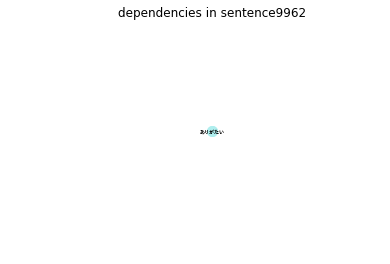

In [8]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("out/44.pdf") as pdf:
    for sid, sentence in enumerate(gen_sentence()):
        node_label = {chunk.index: str(chunk) for chunk in sentence}
        edges = [(chunk.index, chunk.dst) for chunk in sentence if chunk.dst != -1]
        if node_label:
            G = nx.DiGraph()
            G.add_nodes_from(node_label.keys())
            G.add_edges_from(edges)

            # draw graph
            plt.clf()
            plt.title("dependencies in sentence" + str(sid))
            settings = {
                'pos': nx.spring_layout(G, k=1.5, pos=nx.spectral_layout(G)),
                'node_size': 100,
                'node_color': '#afeeee',
                'edge_color': '#888888',
                'labels': node_label,
                'font_family': 'IPAexGothic',
                'with_label': True,
                'font_size': 5,
            }
            nx.draw(G, **settings)

            # save figure to pdf
            pdf.savefig()
            
        print("Page", sid,"Done", end="\r")
        

    

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

### memo
1. 動詞入りの文節を探す
1. 最左動詞を持ってくる
1. 係り元の文節を列挙
1. 係り元の文節内の最右助詞を抽出、ソート

参考: 助詞[(wikipedia)](https://ja.wikipedia.org/wiki/助詞#格助詞)

In [ ]:
with open("out/45_cp.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            verbs_in_chunk = chunk.get("品詞", "動詞")
            if verbs_in_chunk:
                predicate, *rest = verbs_in_chunk # 最左動詞
                chunk_srcs = [sentence[i] for i in chunk.srcs]
                particles_in_chunks = [chunk_src.get("品詞", "助詞") for chunk_src in chunk_srcs]
                particles = [ps[-1].base for ps in particles_in_chunks if ps]
                if particles:
                    f.write(''.join([predicate.base, '\t', ' '.join(sorted(particles)), '\n']))


# 動詞→助詞のペアを列挙
with open("out/45_cp_all.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            verbs_in_chunk = chunk.get("品詞", "動詞")
            if verbs_in_chunk:
                predicate, *rest = verbs_in_chunk # 最左動詞
                chunk_srcs = [sentence[i] for i in chunk.srcs]
                particles_in_chunks = [chunk_src.get("品詞", "助詞") for chunk_src in chunk_srcs]
                particles = [ps[-1].base for ps in particles_in_chunks if ps]
                for p in particles:
                    f.write(''.join([predicate.base, '\t', p, '\n']))

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ

```sort out/45_cp_all.txt | sort -f | uniq -c | sort -k 1r,1 -k 2f,2 > out/45.count```

- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

```grep -E "^する" out/45_cp_all.txt | cut -f 2- | sort | uniq -c | sort -rk 1 | awk '{print $2}' | tr '\n' ' ' > out/45.suru```  
```grep -E "^見る" out/45_cp_all.txt | cut -f 2- | sort | uniq -c | sort -rk 1 | awk '{print $2}' | tr '\n' ' ' > out/45.miru```  
```grep -E "^与える" out/45_cp_all.txt | cut -f 2- | sort | uniq -c | sort -rk 1 | awk '{print $2}' | tr '\n' ' ' > out/45.ataeru```  

## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

### memo
45に加えて...  
タプルで持って助詞で辞書順ソートした後に各々を分けて列挙

In [ ]:
from itertools import chain

with open("out/46.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            verbs_in_chunk = chunk.get("品詞", "動詞")
            if verbs_in_chunk:
                predicate, *rest = verbs_in_chunk
                chunk_srcs = [sentence[i] for i in chunk.srcs]
                particles_in_chunks = [chunk.get("品詞", "助詞") for chunk_src in chunk_srcs]
                pscs = [(str(ps[-1]), str(cs)) for ps, cs in zip(particles_in_chunks, chunk_srcs) if ps]
                pscs.sort(key=lambda t: t[0])
                ps, cs =[p for p, c in pscs], [c for p, c in pscs]
                if pscs:
                    f.write(''.join([predicate.base, '\t', ' '.join(ps), '\t', ' '.join(cs), '\n']))

## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

### memo
46に加えて...  
- 文節が「サ変接続→を」を持つかどうか調べる
- 持ってたらそいつの係り先が動詞を持つか探す、あとは46と同様
- 出力フォーマットを少し修正する

In [ ]:
chunk2sw = lambda chunk: ''.join(["s" if morph.pos1 == "サ変接続" else "w" if str(morph) == "を" else "x" for morph in chunk.morphs])
chunk2xp = lambda chunk: ''.join(["p" if morph.pos == "助詞" else "x" for morph in chunk.morphs])
prg_find_sw = re.compile("sw")
prg_last_particle = re.compile("p[^p]*?$")

with open("out/47.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            # 「サ変->を」の抽出
            match_sw = prg_find_sw.search(chunk2sw(chunk))        
            if match_sw:
                sahen = chunk.morphs[match_sw.start()].surface # サ変名詞を取得
                verbs_in_chunk = sentence[chunk.dst].get("品詞","動詞")
                if verbs_in_chunk:
                    predicate, *rest = verbs_in_chunk # 最左動詞を取得
                    chunk_srcs = [sentence[i] for i in sentence[chunk.dst].srcs if not i == chunk.index] # 係り元の列挙
                    matches_p = [prg_last_particle.search(chunk2xp(chunk_src)) for chunk_src in chunk_srcs] # 最右助詞の探索
                    pscs = [(str(cs.morphs[m.start()]), str(cs)) for m, cs in zip(matches_p, chunk_srcs) if m is not None] # タプルの作成と文字列化
                    if pscs:
                        pscs.sort(key=lambda t: t[0])
                        ps, cs =[p for p, c in pscs], [c for p, c in pscs]
                        f.write(''.join([sahen, 'を', predicate.base, '\t', ' '.join(ps), '\t', ' '.join(cs), '\n']))

## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を"->"で連結する

In [ ]:
with open("out/48.txt", "w", encoding="utf-8") as f:
    for sentence in gen_sentence():
        for chunk in sentence:
            if chunk.get("品詞", "名詞"):
                now_chunk, path = chunk, []
                while True:
                    path.append(str(now_chunk))
                    if now_chunk.dst == -1:
                        break
                    
                    now_chunk = sentence[now_chunk.dst]
                #print(" -> ".join(path))
                f.write(" -> ".join(path))

## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がi
とj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"->"で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

1. 文節iから構文木の根に至る経路上に文節jが存在する場合

文節iから文節jのパスを表示

2. 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合  

文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を"|"で連結して表示

In [ ]:
from itertools import combinations

def chunk_path(sentence, start_index):
    chunk, path = sentence[start_index], []
    while True:
        path.append(chunk)
        if chunk.dst == -1:
            break
            
        chunk = sentence[chunk.dst]
        
    return path

with open("out/49.txt", "w", encoding="utf-8") as f:
    for n, sentence in enumerate(gen_sentence()):
        f.write("sentence "+str(n)+"\n")
        
        # 名詞句を抽出
        indexes = [chunk.index for chunk in sentence if chunk.get("品詞", "名詞")]
        if len(indexes) < 2:
            continue
            
        for i, j in combinations(indexes, 2):
            path_i = chunk_path(sentence, i)
            path_i_indexes = list(map(int, path_i))
            chunk_i, *rest_i = path_i
            subX = ''.join(["X" if morph.check("品詞","名詞") else str(morph) for morph in chunk_i.morphs])
            
            if j in path_i_indexes: # (1)
                end = list(map(int, rest_i)).index(j)
        
                f.write(' -> '.join([subX] + list(map(str,rest_i[:end])) + ["Y"]) + "\n")
            else: # (2)
                path_j = chunk_path(sentence, j)
                path_j_indexes = list(map(int, path_j))
                chunk_j, *rest_j = path_j
                subY = ''.join(["Y" if morph.check("品詞","名詞") else str(morph) for morph in chunk_j.morphs])
                k = min(set(path_i_indexes) & set(path_j_indexes))
                string_k = str(sentence[k])
                
                end_i = list(map(int, rest_i)).index(k)
                string_ik = ' -> '.join([subX] + list(map(str,rest_i[:end_i])))
                
                end_j = list(map(int, rest_j)).index(k)
                string_jk = ' -> '.join([subY] + list(map(str,rest_j[:end_j])))
                
                f.write(" | ".join([string_ik, string_jk, string_k]) + "\n")
                